# Module 2: Water flow in soil

*by Daniel Leitner, Andrea Schnepf*

## Theory


In this module, we describe benchmark problems that only relate to water flow in soil. 
Water flow in soil is most commonly described by the Richards equation: 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}=  \nabla \cdot\left( K_c(\theta) \left( \nabla \psi_s - e_3 \right) \right),
\end{eqnarray}
in three dimesnions, where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [cm / day], and  $\psi_s$ is the soil matric potential [cm]. 


The relationship between soil water potential and water content is generally described by the water retention curve. In the following we will use the Mualem Van Genuchten model (Van Genuchten, 1980) to describe this curve specifying the soil moisture characteristic of specific soils. 

## Benchmarks


Benchmarks for water movement in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe two relevant benchmarks and implement their analytical solutions. The derivation is given by Vanderborght et al. (2005).  

In [5]:
# We first import libraries and define some auxiliary functions:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

In [6]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$ [1], $\theta_s$ [1], $\alpha$ [1/cm], $n$ [1], and $K_s$ [cm / day]:

In [7]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark M2.1: Infiltration


For each of the soil types, sand, loam and clay, we consider infiltration into an initially dry soil profile of 200 cm depth, with a matric potential of -400 cm everywhere. 

At the top boundary we prescribe an influx of 100 cm/day if the soil matric potential is negative ($\psi_s(z=0) < 0$ cm), else we prescribe full saturation as Dirichlet boundary condition ($\psi_s(z=0)= 0$ cm). At the bottom free drainage boundary conditions is used.

The analytical solution of Benchmark M2.1 is calculated by the following code and reproduces Figure 4abc from Vanderborght et al. (2005), where the water content is plotted for different times: 0.1, 0.2, and 0.3 days for Scenario 1; 0.2, 0.5, and 1 days for Scenario 2; 0.1, 0.2, and 0.5 days for Scenario 3.

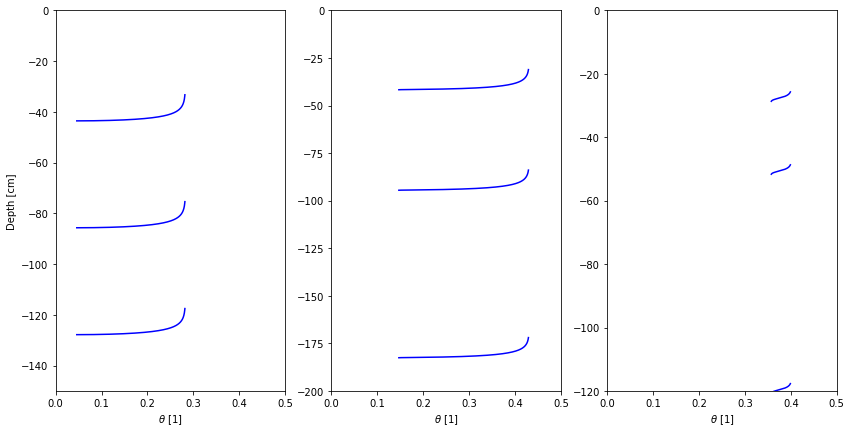

In [8]:
tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)
t_a2 = [0.1, 0.2, 0.1] 
x_aa = [43, 41, 27.5] # TODO how to choose reference water content and its position ?    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax = [ax1,ax2,ax3]
theta3 = []
z3 = []

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824 # calculated form the influx 100 cm/day
    else:
        theta_sur = soil.theta_S  # full saturation          
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,1000)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    x_a = x_aa[i]
    t_a = t_a2[i]        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a

    # finally, plot the thing    
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        ax[i].plot(theta_,-x,'b-')
        theta3.append(theta_) # remember results for evaluation
        z3.append(-x)
    ax[i].set_xlabel(r'$\theta$ [1]')
    ax[i].set_xlim(0,0.5)

ax1.set_ylabel('Depth [cm]')
ax1.set_ylim(-150,0)
ax2.set_ylim(-200,0)
ax3.set_ylim(-120,0)
plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
